## 1.Imports of libraries


In [51]:
# Standard Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data Acquisition and Analysis
import yfinance as yf  # For downloading market data
import pandas_ta as ta  # Technical Analysis library
import talib  # Additional Technical Analysis library

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


## 2.Load dataset

In [56]:
#Remove the Volume and Adj Close columns 
df.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

## 3.Features Engineering

In [54]:
#Display Technical Indicators of the library Talib
df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [41]:
# Adding indicators

#Relative Strenght Index Indicator
df['RSI']=ta.rsi(df.Close, length=15)

#Exponential Moving Average over 13 periods(Short-Term)
df['EMAF']=ta.ema(df.Close, length=13)
#Exponential Moving Average over 13 periods(Medium-Term)
df['EMAM']=ta.ema(df.Close, length=50)
#Exponential Moving Average over 13 periods(Long-Term)
df['EMAS']=ta.ema(df.Close, length=200)

#Create a  new column for the target variable  
df['TargetNextClose'] = df['Close'].shift(-1)
#Clean any rows with NaN values
df.dropna(inplace=True)

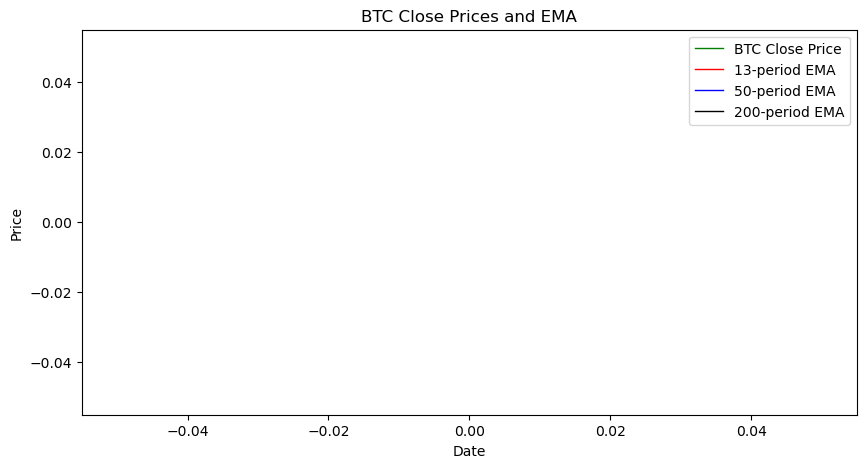

In [42]:
# Plotting the Closing Prices and EMAs

# Set the figure size 
plt.figure(figsize=(10, 5))  

# Plot Close prices with increased thickness
plt.plot(df['Close'], label='BTC Close Price', color='green', linewidth=1)  # Increased line thickness

# Plot Exponential Moving Averages with dotted lines
plt.plot(df['EMAF'], label='13-period EMA', color='red', linestyle='-', linewidth=1)
plt.plot(df['EMAM'], label='50-period EMA', color='blue', linestyle='-', linewidth=1)
plt.plot(df['EMAS'], label='200-period EMA', color='black', linestyle='-', linewidth=1)

#Assign labels
plt.title('BTC Close Prices and EMA')
plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()
plt.show()


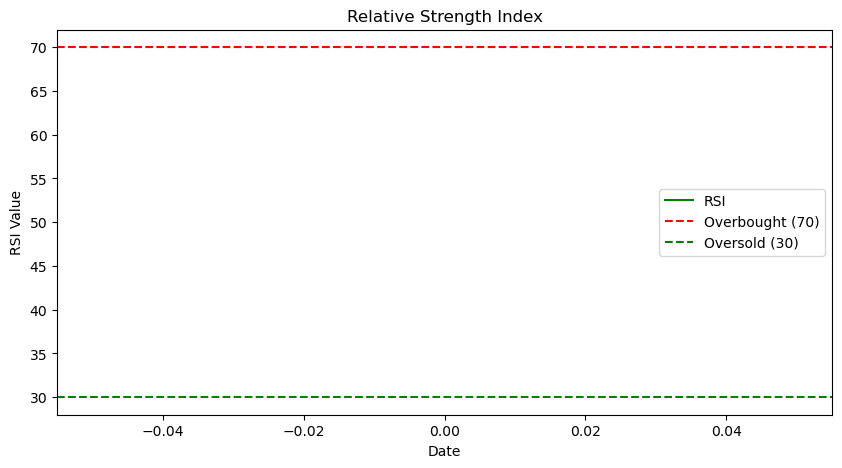

In [17]:
# Plot the RSI indicator
plt.figure(figsize=(10, 5))  # New figure for RSI


plt.plot(df['RSI'], label='RSI', color='green')

# Overbought line (70)
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)') 
 # Oversold line (30)
plt.axhline(30, linestyle='--', color='green', label='Oversold (30)') 

#Assign labels
plt.title('Relative Strength Index')
plt.xlabel('Date')
plt.ylabel('RSI Value')

plt.legend()
plt.show()

In [18]:
#Double check if any row still contains a missing values
df.isnull().sum()

Open               0.0
High               0.0
Low                0.0
Close              0.0
RSI                0.0
EMAF               0.0
EMAM               0.0
EMAS               0.0
TargetNextClose    0.0
dtype: float64

## 4.Scale the data

In [19]:
#Scale/Normalize the features using MinMax(0,1) and convert to dataframe

scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Close', 'RSI', 'EMAF', 'EMAM', 'EMAS']
df_scaled = scaler.fit_transform(df[features + ['TargetNextClose']])
df_scaled = pd.DataFrame(df_scaled, columns=features + ['TargetNextClose'])


ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required by MinMaxScaler.

## 5.Function: Create Sequences for LSTM Model

In [20]:
#Prepares Sequential Data for Time Series Forecasting

def create_sequences(df_scaled, sequence_length):
    X, y = [], []
    for i in range(len(df_scaled) - sequence_length):
        X.append(df_scaled.iloc[i:(i + sequence_length)][features].values)
        y.append(df_scaled.iloc[i + sequence_length]['TargetNextClose'])
    return np.array(X), np.array(y)
#window size 
sequence_length = 4

X, y = create_sequences(df_scaled, sequence_length)

NameError: name 'df_scaled' is not defined

## 6.Data Partitioning: 80-10-10 Split
## Splitting the Data into Training, Validation, and Testing Sets



In [21]:
#Data partioning 80-10-10

#Assign the sizes
train_size = int(X.shape[0] * 0.8)
val_size = int(X.shape[0] * 0.1)
test_size = X.shape[0] - train_size - val_size

#Data for training
X_train, y_train = X[:train_size], y[:train_size]
#Data for validation
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
#Data for testing
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Print the shapes of the datasets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)



NameError: name 'X' is not defined

## 7. Build LSTM Model with Dropout

In [22]:
#1.Build LSTM model
def build_model():
    model = Sequential([
        
        #first layer with 32 units that return sequences for further layers, and accepts input shaped as (sequence_length, number of features) 
        LSTM(32, input_shape=(sequence_length, len(features)), return_sequences=True),
        
        # Dropout for regularization
        Dropout(0.2), 
        
        #Second laayers with 32 units with no sequence, output only last hidden ones
        LSTM(32, return_sequences=False),
        
        # Dropout for regularization
        Dropout(0.2),  
        
        # Output layer with 1 output unit
        Dense(1)  
    ])
    
    #Compile the model and adam as optimizer and mse as loss
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model()

In [23]:
# 2. Print a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 32)             5248      
                                                                 
 dropout (Dropout)           (None, 4, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________


## 8. Train the Model


In [24]:
#3. Train the model

#Stop the training when val_loss is not improving after 10 epochs 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Train the model 
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])


NameError: name 'X_train' is not defined

## 9.Evaluation of the model

In [ ]:
# 4. Plot training loss vs. validation loss

plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Standard linear scale for y-axis
plt.title('Training vs. Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
# 5. Evaluate the model on the test data

test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

NameError: name 'X_test' is not defined

In [26]:
# 6.Prediction on validation and test sets
val_predictions = model.predict(X_val)

#Flatt the prediction in a one dimentional array for metrics analysis
val_predictions = val_predictions.flatten()


NameError: name 'X_val' is not defined

In [27]:
# 7. Calculate validation metrics

val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, val_predictions)
val_mape = np.mean(np.abs((y_val - val_predictions) / y_val)) * 100
val_r2 = r2_score(y_val, val_predictions)

print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation MAPE: {val_mape}%")
print(f"Validation R-squared: {val_r2}")


NameError: name 'y_val' is not defined

In [28]:
#8.Plot the validation data

plt.figure(figsize=(10, 5))
plt.plot(y_val,marker = '.', linestyle='-', label='Actual Validation Data')
plt.plot(val_predictions, label='Predicted Validation Data')
plt.title('Validation Data: Actual vs Predicted')
plt.legend()
plt.show()

NameError: name 'y_val' is not defined

<Figure size 1000x500 with 0 Axes>

In [29]:
#9.Predictions for the test data
test_predictions = model.predict(X_test)

#Flatt the prediction in a one dimentional array for metrics analysis
test_predictions = test_predictions.flatten() 

NameError: name 'X_test' is not defined

In [30]:
# 10.Calculation of Testing metrics

#Test metrics
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)
test_mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100
test_r2 = r2_score(y_test, test_predictions)

# Print metrics for testing evaluation
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}%")
print(f"Test R-squared: {test_r2}")



NameError: name 'y_test' is not defined

In [31]:
# 11.Plot the Test data

plt.figure(figsize=(10, 5))

plt.plot(y_test, marker='.', label='Actual Test Data')
plt.plot(test_predictions, label='Predicted Test Data')

plt.title('Test Data: Actual vs Predicted')

plt.legend()
plt.show()

NameError: name 'y_test' is not defined

<Figure size 1000x500 with 0 Axes>

In [32]:
# Save the model
model_path = r'C:\Users\Hamza\Desktop\FYP\my_trained_model.h5'
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to C:\Users\Hamza\Desktop\FYP\my_trained_model.h5
